In [194]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from os import path
from wordcloud import WordCloud
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
import xgboost as xgb
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re
from string import punctuation

In [195]:
#Read in training data
train_data_raw = pd.read_csv("train.csv")
train_data_raw.fillna('empty')
train_data_raw.head(5)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


length of the training data 2425740
Ratio of duplicate question pairs: 36.92
Total number of questions: 537933
Number of questions appearing multiple times: 111780


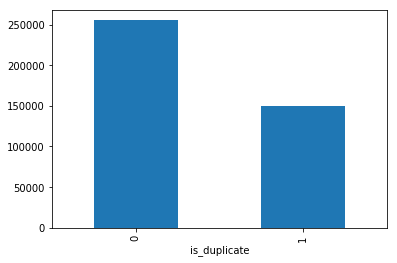

In [196]:
print("length of the training data {}".format(train_data_raw.size))
print("Ratio of duplicate question pairs: {}".format(round(train_data_raw['is_duplicate'].mean()*100,2)))
qids = pd.Series(train_data_raw['qid1'].tolist() + train_data_raw['qid2'].tolist())
print("Total number of questions: {}".format(len(np.unique(qids))))
print("Number of questions appearing multiple times: {}".format(np.sum(qids.value_counts()>1)))
train_data_raw.groupby("is_duplicate")['id'].count().plot.bar()

In [197]:
test_data_raw = pd.read_csv("test.csv")
test_data_raw.fillna('empty')
print("Length of the testing data {}".format(len(test_data_raw)))
test_data_raw.head()

Length of the testing data 2345796


,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


(-0.5, 1279.5, 979.5, -0.5)

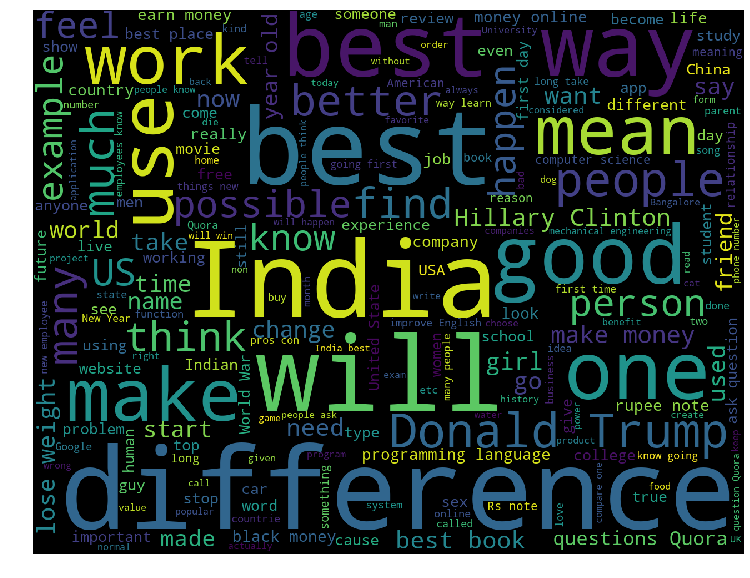

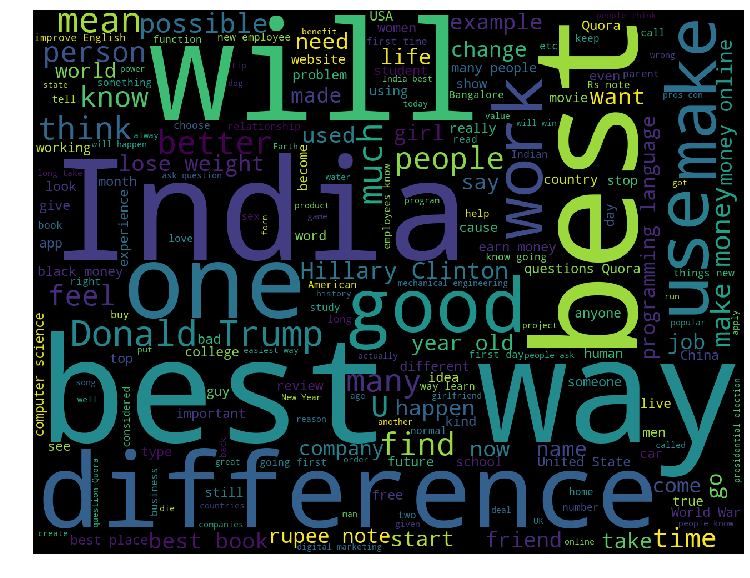

In [198]:
cloud1 = WordCloud(width=1280, height=980).generate(" ".join(train_data_raw['question1'].astype(str)))
cloud2 = WordCloud(width=1280, height=980).generate(" ".join(train_data_raw['question2'].astype(str)))
plt.figure(figsize=(15, 10))
plt.imshow(cloud1)
plt.axis('off')
plt.figure(figsize=(15, 10))
plt.imshow(cloud2)
plt.axis('off')

When looking at the above two plot, there are lot of common words between question 1 and question 2 in the dataset

In [139]:
from nltk.corpus import stopwords
stop_words = ['the','a','an','and','but','if','or','because','as','what','which','this','that','these','those','then',
              'just','so','than','such','both','through','about','for','is','of','while','during','to','What','Which',
              'Is','If','While','This']

In [199]:
def text_to_wordlist(text, remove_stop_words=False, stem_words=False):
    # Clean the text, with the option to remove stop_words and to stem words.
    try:
        # Clean the text
        text = re.sub(r"[^A-Za-z0-9]", " ", text)
        text = re.sub(r"what's", "", text)
        text = re.sub(r"What's", "", text)
        text = re.sub(r"\'s", " ", text)
        text = re.sub(r"\'ve", " have ", text)
        text = re.sub(r"can't", "cannot ", text)
        text = re.sub(r"n't", " not ", text)
        text = re.sub(r"I'm", "I am", text)
        text = re.sub(r" m ", " am ", text)
        text = re.sub(r"\'re", " are ", text)
        text = re.sub(r"\'d", " would ", text)
        text = re.sub(r"\'ll", " will ", text)
        text = re.sub(r"60k", " 60000 ", text)
        text = re.sub(r" e g ", " eg ", text)
        text = re.sub(r" b g ", " bg ", text)
        text = re.sub(r"\0s", "0", text)
        text = re.sub(r" 9 11 ", "911", text)
        text = re.sub(r"e-mail", "email", text)
        text = re.sub(r"\s{2,}", " ", text)
        text = re.sub(r"quikly", "quickly", text)
        text = re.sub(r" usa ", " America ", text)
        text = re.sub(r" USA ", " America ", text)
        text = re.sub(r" u s ", " America ", text)
        text = re.sub(r" uk ", " England ", text)
        text = re.sub(r" UK ", " England ", text)
        text = re.sub(r"india", "India", text)
        text = re.sub(r"switzerland", "Switzerland", text)
        text = re.sub(r"china", "China", text)
        text = re.sub(r"chinese", "Chinese", text) 
        text = re.sub(r"imrovement", "improvement", text)
        text = re.sub(r"intially", "initially", text)
        text = re.sub(r"quora", "Quora", text)
        text = re.sub(r" dms ", "direct messages ", text)  
        text = re.sub(r"demonitization", "demonetization", text) 
        text = re.sub(r"actived", "active", text)
        text = re.sub(r"kms", " kilometers ", text)
        text = re.sub(r"KMs", " kilometers ", text)
        text = re.sub(r" cs ", " computer science ", text) 
        text = re.sub(r" upvotes ", " up votes ", text)
        text = re.sub(r" iPhone ", " phone ", text)
        text = re.sub(r"\0rs ", " rs ", text) 
        text = re.sub(r"calender", "calendar", text)
        text = re.sub(r"ios", "operating system", text)
        text = re.sub(r"gps", "GPS", text)
        text = re.sub(r"gst", "GST", text)
        text = re.sub(r"programing", "programming", text)
        text = re.sub(r"bestfriend", "best friend", text)
        text = re.sub(r"dna", "DNA", text)
        text = re.sub(r"III", "3", text) 
        text = re.sub(r"the US", "America", text)
        text = re.sub(r"Astrology", "astrology", text)
        text = re.sub(r"Method", "method", text)
        text = re.sub(r"Find", "find", text) 
        text = re.sub(r"banglore", "Banglore", text)
        text = re.sub(r" J K ", " JK ", text)

        # Remove punctuation from text
        text = ''.join([c for c in text if c not in punctuation])

        # Optionally, remove stop words
        if remove_stop_words:
            text = text.split()
            text = [w for w in text if not w in stop_words]
            text = " ".join(text)

        # Optionally, shorten words to their stems
        if stem_words:
            text = text.split()
            stemmer = SnowballStemmer('english')
            stemmed_words = [stemmer.stem(word) for word in text]
            text = " ".join(stemmed_words)
    except:
        print(str(text))
    
    # Return a list of words
    return(text)

In [200]:
def process_questions(question_list, questions, question_list_name, dataframe):
    '''transform questions and display progress'''
    for question in questions:
        question_list.append(text_to_wordlist(question))
        if len(question_list) % 100000 == 0:
            progress = len(question_list)/len(dataframe) * 100
            print("{} is {}% complete.".format(question_list_name, round(progress, 1)))

In [201]:
train_data_cleaned = train_data_raw
train_data_cleaned['question1'] = train_data_cleaned.apply(lambda x: text_to_wordlist(x['question1']),axis=1)
train_data_cleaned['question2'] = train_data_cleaned.apply(lambda x: text_to_wordlist(x['question2']), axis=1)

nan
nan
nan


In [202]:
train_data_cleaned.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor Koh i Noor Diamond,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely How can I solve it,find the remainder when math 23 24 math is div...,0
4,4,9,10,Which one dissolve in water quickly sugar salt...,Which fish would survive in salt water,0


In [203]:
test_data_cleaned = test_data_raw
test_data_cleaned['question1'] = test_data_cleaned.apply(lambda x: text_to_wordlist(x['question1']),axis=1)
test_data_cleaned['question2'] = test_data_cleaned.apply(lambda x: text_to_wordlist(x['question2']), axis=1)

nan
nan
nan
nan
nan
nan


In [204]:
test_data_cleaned.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24 How ...,How much cost does hair transplant require
2,2,What but is the best way to send money from Ch...,What you send money to China
3,3,Which food not emulsifiers,What foods fibre
4,4,How aberystwyth start reading,How their can I start reading


In [205]:
def word_share_norm(x):
    w1 = set(map(lambda word: word.lower().strip(), str(x['question1']).split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), str(x['question2']).split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))

In [206]:
train_questions = pd.Series(train_data_cleaned['question1'].tolist() + train_data_cleaned['question2'].tolist()).astype(str)
test_questions = pd.Series(test_data_cleaned['question1'].tolist() + test_data_cleaned['question2'].tolist()).astype(str)
def get_weight(count, eps=5000, min_count=2):
    if count < min_count:
        return 0 #remove words only appearing once 
    else:
        R = 1.0 / (count + eps)
        return R

eps = 5000 
words = (" ".join(train_questions)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}
print ("Most common words: ", (sorted(weights.items(), key=lambda x: x[1] if x[1] > 0 else 9999)[:10]))

Most common words:  [('the', 2.6403895102605537e-06), ('what', 3.0335848175147054e-06), ('is', 3.6373688728521336e-06), ('i', 4.380681195925966e-06), ('how', 4.426815879873924e-06), ('a', 4.602822450726786e-06), ('to', 4.7434954818205534e-06), ('in', 4.943691355461296e-06), ('do', 6.0214846572570936e-06), ('of', 6.065164123341178e-06)]


In [207]:
def tfidf_word_share_norm(x):
    w1 = set(map(lambda word: word.lower().strip(), str(x['question1']).split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), str(x['question2']).split(" "))) 
    if len(w1)==0 or len(w2)==0:
        return 0
    common = w1 & w2
    share_weight = [weights.get(word, 0) for word in common]
    total_weight = [weights.get(word, 0) for word in w1]+[weights.get(word, 0) for word in w2]
    return np.sum(share_weight)/np.sum(total_weight)

In [210]:
train_data_cleaned.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor Koh i Noor Diamond,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely How can I solve it,find the remainder when math 23 24 math is div...,0
4,4,9,10,Which one dissolve in water quickly sugar salt...,Which fish would survive in salt water,0


In [208]:
train_data = pd.DataFrame(dtype='float64')
train_data['q1chrlen'] = train_data_cleaned['question1'].str.len()
train_data['q2chrlen'] = train_data_cleaned['question2'].str.len()
train_data['q1_nword'] = train_data_cleaned['question1'].apply(lambda x: len(str(x).split(" ")))
train_data['q2_nword'] = train_data_cleaned['question2'].apply(lambda y: len(str(y).split(" ")))
train_data['word_share'] = train_data_cleaned.apply(word_share_norm, axis=1)
train_data['TFIDF_share'] = train_data_cleaned.apply(tfidf_word_share_norm, axis=1, raw=True)
train_data.head()

,q1chrlen,q2chrlen,q1_nword,q2_nword,word_share,TFIDF_share
0,66.0,57.0,15,13,0.480000,0.491820
1,49.0,86.0,11,16,0.307692,0.335038
2,73.0,59.0,15,11,0.192308,0.141294
3,49.0,60.0,12,14,0.045455,0.000000
4,75.0,39.0,14,8,0.227273,0.133743


In [211]:
np.sum(np.isnan(train_data))
train_data.loc[:,'q1chrlen'] = np.nan_to_num(train_data.loc[:,'q1chrlen'])
train_data.loc[:,'q2chrlen'] = np.nan_to_num(train_data.loc[:,'q2chrlen'])
train_data.loc[:,'TFIDF_share'] = np.nan_to_num(train_data.loc[:,'TFIDF_share'])
np.sum(np.isnan(train_data))

q1chrlen       0
q2chrlen       0
q1_nword       0
q2_nword       0
word_share     0
TFIDF_share    0
dtype: int64

In [212]:
test_data = pd.DataFrame(dtype='float64')
test_data['q1chrlen'] = test_data_cleaned['question1'].str.len()
test_data['q2chrlen'] = test_data_cleaned['question2'].str.len()
test_data['q1_nword'] = test_data_cleaned['question1'].apply(lambda x: len(str(x).split(" ")))
test_data['q2_nword'] = test_data_cleaned['question2'].apply(lambda y: len(str(y).split(" ")))
test_data['word_share'] = test_data_cleaned.apply(word_share_norm, axis=1)
test_data['TFIDF_share'] = test_data_cleaned.apply(tfidf_word_share_norm, axis=1)

In [213]:
test_data.head()
np.sum(np.isnan(test_data))
test_data.loc[:,'q1chrlen'] = np.nan_to_num(test_data.loc[:,'q1chrlen'])
test_data.loc[:,'q2chrlen'] = np.nan_to_num(test_data.loc[:,'q2chrlen'])
test_data.loc[:,'TFIDF_share'] = np.nan_to_num(test_data.loc[:,'TFIDF_share'])
np.sum(np.isnan(test_data))

q1chrlen       0
q2chrlen       0
q1_nword       0
q2_nword       0
word_share     0
TFIDF_share    0
dtype: int64

/Users/rishwanthsenthilkumar/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0, 0.5, 'Probability')

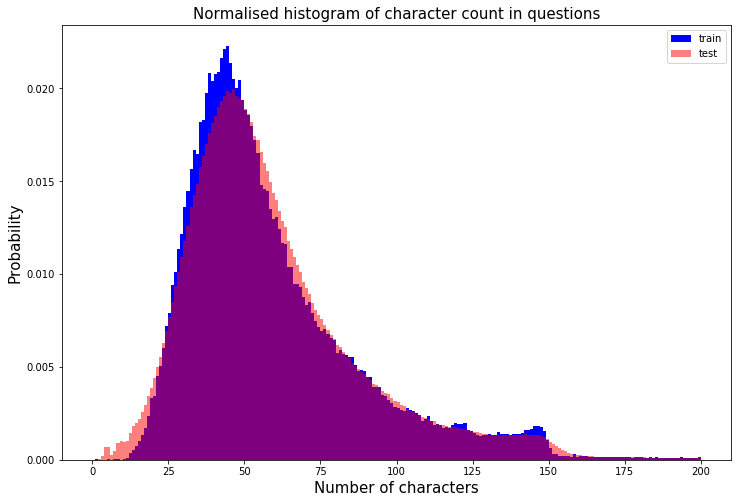

In [214]:
train_qs = pd.Series(train_data_cleaned['question1'].tolist() + train_data_cleaned['question2'].tolist()).astype(str)
test_qs = pd.Series(test_data_cleaned['question1'].tolist() + test_data_cleaned['question2'].tolist()).astype(str)
dist_train = train_qs.apply(len)
dist_test = test_qs.apply(len)
plt.figure(figsize=(12, 8))
plt.hist(dist_train, bins=200, range=[0, 200], color='blue', normed=True, label='train')
plt.hist(dist_test, bins=200, range=[0, 200], color='red',alpha = 0.5, normed=True, label='test')
plt.title('Normalised histogram of character count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

Text(0, 0.5, 'Probability')

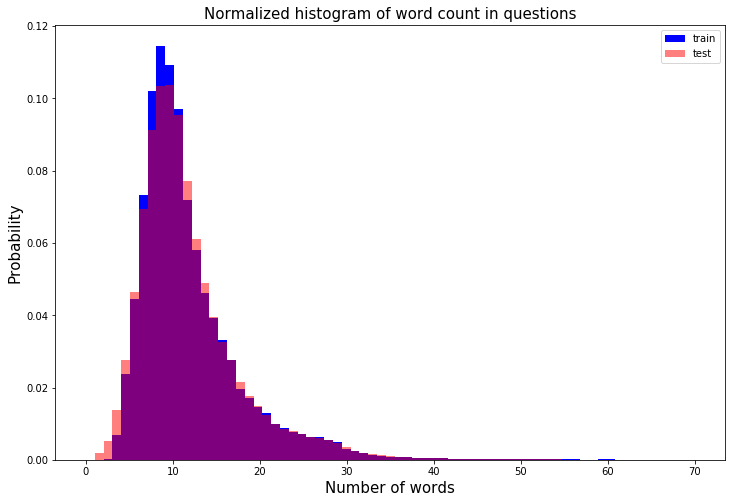

In [215]:
dist_train = train_qs.apply(lambda x: len(x.split(' ')))
dist_test = test_qs.apply(lambda x: len(x.split(' ')))
plt.figure(figsize=(12, 8))
plt.hist(dist_train, bins=np.linspace(0, 70, 70), range=[0, 70], normed = True, color='blue', label='train')
plt.hist(dist_test, bins=np.linspace(0, 70, 70), range=[0, 70], normed = True, color='red',alpha = 0.5, label='test')
plt.title('Normalized histogram of word count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

Text(0.5, 0, 'word_share_ratio')

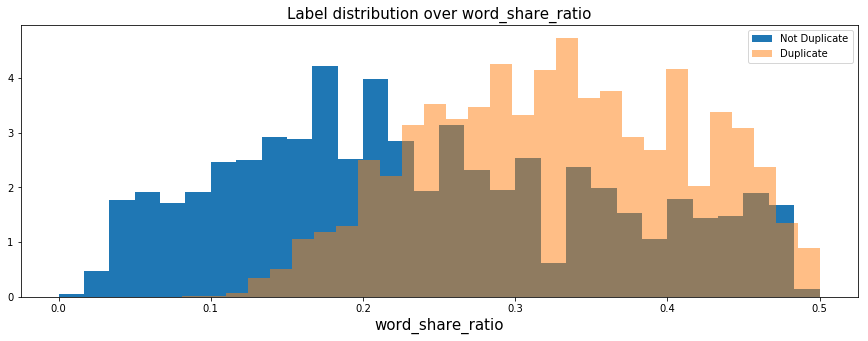

In [216]:
plt.figure(figsize=(15, 5))
train_word_share = train_data['word_share']
plt.hist(train_word_share[train_data_cleaned['is_duplicate'] == 0], bins=30, normed=True, label='Not Duplicate')
plt.hist(train_word_share[train_data_cleaned['is_duplicate'] == 1], bins=30, normed=True, alpha=0.5, label='Duplicate')
plt.legend()
plt.title('Label distribution over word_share_ratio', fontsize=15)
plt.xlabel('word_share_ratio', fontsize=15)

Text(0.5, 0, 'TFIDF_share')

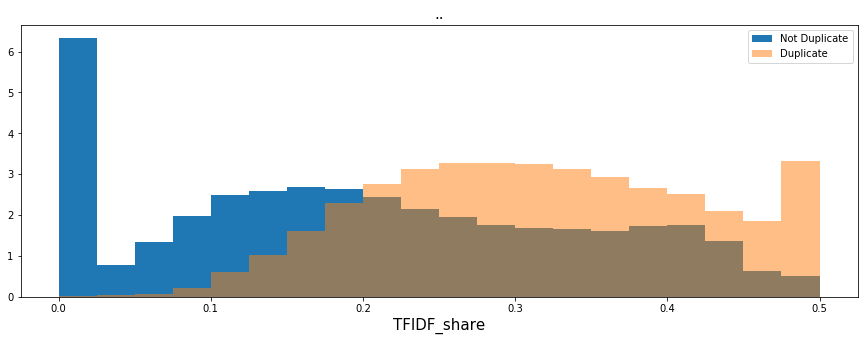

In [217]:
plt.figure(figsize=(15, 5))
train_tfidf = train_data['TFIDF_share'].fillna(0)
plt.hist(train_tfidf[train_data_cleaned['is_duplicate'] == 0], bins=20, normed=True, label='Not Duplicate')
plt.hist(train_tfidf[train_data_cleaned['is_duplicate'] == 1], bins=20, normed=True, alpha=0.5, label='Duplicate')
plt.legend()
plt.title('..', fontsize=15)
plt.xlabel('TFIDF_share', fontsize=15)

In [226]:
label = train_data_cleaned['is_duplicate']
pos_train = train_data[label == 1]
neg_train = train_data[label == 0]

# Now we oversample the negative class
# There is likely a much more elegant way to do this...
p = 0.165
scale = ((len(pos_train) / (len(pos_train) + len(neg_train))) / p) - 1
while scale > 1:
    neg_train = pd.concat([neg_train, neg_train])
    scale -=1
neg_train = pd.concat([neg_train, neg_train[:int(scale * len(neg_train))]])
print(len(pos_train) / (len(pos_train) + len(neg_train)))

train_data = pd.concat([pos_train, neg_train])
label = (np.zeros(len(pos_train)) + 1).tolist() + np.zeros(len(neg_train)).tolist()
del pos_train, neg_train

0.19124366100096607


In [242]:
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.fit_transform(test_data)

In [243]:
X_train, X_valid, y_train, y_valid = train_test_split(train_data, label, test_size=0.2, random_state=10)
X_train_scaled, X_valid_scaled, y_train, y_valid = train_test_split(train_data_scaled, label, test_size=0.2, random_state=10)

# Benchmark Model

Random Forest Classifier

In [261]:
rfc = RandomForestClassifier(max_depth=5, random_state=0)
rfc.fit(X_train_scaled,y_train)
prediction = rfc.predict_proba(X_valid_scaled)
pre = rfc.predict(X_valid_scaled)
score_rfc = rfc.score(X_valid_scaled, y_valid)
print("Random Forest (Benchmark model) has accuracy: {}".format(score_rfc))

/Users/rishwanthsenthilkumar/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random Forest (Benchmark model) has accuracy: 0.8108303757895681


In [262]:
prediction = rfc.predict_proba(test_data_scaled)
sub = pd.DataFrame({'test_id': test_data_cleaned['test_id'], 'is_duplicate': prediction[:,1]})
sub.to_csv('rfc_submission.csv', index=False)

Random Forest Classifier Kaggle leaderboard score: 0.42912

Logistic Regression

In [244]:
lr = LogisticRegression(random_state=10, solver = "liblinear")
grid = {
    'C': [1e-6, 1e-3, 1e0, 1e3, 1e6],
    'penalty': ['l1', 'l2']
}
cv = GridSearchCV(lr, grid, scoring='neg_log_loss', cv = 3,verbose = True)
cv.fit(X_train_scaled, y_train)
print(cv.best_params_)
score_lr = cv.best_estimator_.score(X_valid_scaled, y_valid)
print("Logistic regression model accuracy: {}".format(score_lr))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   56.9s finished


{'C': 1.0, 'penalty': 'l2'}
Logistic regression model accuracy: 0.8123742776973439


In [245]:
lr = LogisticRegression(C = 1.0, penalty = 'l2', random_state=10, solver = "liblinear")
lr.fit(X_train_scaled, y_train)
prediction = lr.predict_proba(test_data_scaled)
sub = pd.DataFrame({'test_id': test_data_cleaned['test_id'], 'is_duplicate': prediction[:,1]})
sub.to_csv('lr_submission.csv', index=False)

Kaggle Leaderboard score: 0.44061

Decision Tree Classifier

In [258]:
dt = DecisionTreeClassifier(max_depth = 10, random_state=10)
dt.fit(X_train_scaled, y_train)
prediction = dt.predict(X_valid_scaled)
score_dt = dt.score(X_valid_scaled, y_valid)
print("Decision tree model accuracy: {}".format(score_dt))

Decision tree model accuracy: 0.8179028558982178


In [259]:
prediction = dt.predict_proba(test_data_scaled)
sub = pd.DataFrame({'test_id': test_data_cleaned['test_id'], 'is_duplicate': prediction[:,1]})
sub.to_csv('dt_submission.csv', index=False)

Decision tree classifier Kaggle leaderboard score: 0.97583

In [266]:
svm = SVC(random_state=0, max_iter=500, probability=True)
grid = {
    'C': [1e-3, 1e0, 1e3],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}
cv = GridSearchCV(svm, grid, scoring='neg_log_loss', verbose = True)
cv.fit(X_train_scaled, y_train)
print(cv.best_params_)
score_svm = cv.best_estimator_.score(X_valid_scaled, y_valid)
print("SVM model accuracy: {}".format(score_svm))

/Users/rishwanthsenthilkumar/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/rishwanthsenthilkumar/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/rishwanthsenthilkumar/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/rishwanthsenthilkumar/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/rishwanthsenthilkumar/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The def

KeyboardInterrupt: 

In [268]:
svm = SVC(random_state=0, max_iter=1000, probability=True, kernel='linear', C=1000)
svm.fit(X_train_scaled, y_train)
prediction = svm.predict_proba(test_data_scaled)
sub = pd.DataFrame({'test_id': test_data_cleaned['test_id'], 'is_duplicate': prediction[:,1]})
sub.to_csv('svm_submission.csv', index=False)

/Users/rishwanthsenthilkumar/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Kaggle leaderboard SVM: 0.46056

In [250]:
knn = KNeighborsClassifier()
grid = {
    'n_neighbors': list(range(2, 10, 2)),
    'weights': ['uniform', 'distance']
}
cv = GridSearchCV(knn, grid, scoring='neg_log_loss', verbose = True)
cv.fit(X_train_scaled, y_train)
print(cv.best_params_)
score_knn = cv.best_estimator_.score(X_valid_scaled, y_valid)
print("K Nearest Neighbor model accuracy: {}".format(score_knn))

/Users/rishwanthsenthilkumar/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  5.7min finished


{'n_neighbors': 8, 'weights': 'distance'}
K Nearest Neighbor model accuracy: 0.8632846032620534


In [252]:
knn = KNeighborsClassifier(n_neighbors = 8, weights = 'distance')
knn.fit(X_train_scaled, y_train)
prediction = knn.predict_proba(test_data_scaled)
sub = pd.DataFrame({'test_id': test_data_cleaned['test_id'], 'is_duplicate': prediction[:,1]})
sub.to_csv('knn_submission.csv', index=False)

K nearest neighbor Kaggle leaderboard score: 1.58297

In [253]:
mnb = MultinomialNB().fit(X_train, y_train)
score_nb = mnb.score(X_valid,y_valid)
print("Naive Bayes model accuracy: {}".format(score_nb))

Naive Bayes model accuracy: 0.8085753821317377


In [255]:
prediction = mnb.predict_proba(test_data_final)
sub = pd.DataFrame({'test_id': test_data_cleaned['test_id'], 'is_duplicate': prediction[:,1]})
sub.to_csv('nb_submission.csv', index=False)

Naive bayes Kaggle leaderboard score: 0.43363

In [264]:
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 5

d_train = xgb.DMatrix(X_train, label=y_train)
d_valid = xgb.DMatrix(X_valid, label=y_valid)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]
bst = xgb.train(params, d_train, 500, watchlist, early_stopping_rounds=50, verbose_eval=10)
d_test = xgb.DMatrix(test_data)
p_test = bst.predict(d_test)

[0]	train-logloss:0.683719	valid-logloss:0.683801
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.607286	valid-logloss:0.607288
[20]	train-logloss:0.553593	valid-logloss:0.553639
[30]	train-logloss:0.514829	valid-logloss:0.514971
[40]	train-logloss:0.486282	valid-logloss:0.486495
[50]	train-logloss:0.464789	valid-logloss:0.465141
[60]	train-logloss:0.448688	valid-logloss:0.448976
[70]	train-logloss:0.43627	valid-logloss:0.43659
[80]	train-logloss:0.42653	valid-logloss:0.427041
[90]	train-logloss:0.419101	valid-logloss:0.419676
[100]	train-logloss:0.413361	valid-logloss:0.413941
[110]	train-logloss:0.408891	valid-logloss:0.409458
[120]	train-logloss:0.405215	valid-logloss:0.405933
[130]	train-logloss:0.402457	valid-logloss:0.403185
[140]	train-logloss:0.400314	valid-logloss:0.401008
[150]	train-logloss:0.398397	valid-logloss:0.39917
[160]	train-logloss:0.39678	vali

In [265]:
sub = pd.DataFrame({'test_id': test_data_cleaned['test_id'], 'is_duplicate': p_test})
sub.to_csv('xgb_submission.csv', index=False)

XGBoost Kaggle leaderboard score: 0.39127